In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=transformation)
valid_dataset = FashionMNIST(root="./data", train=False, download=True, transform=transformation)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.2MB/s]


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


In [4]:
# train_dataset[0]
train_dataset[0][0].shape # 28 x 28 representation of the first image in training data
train_dataset[0][1] # label of the first image of the training data

9

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

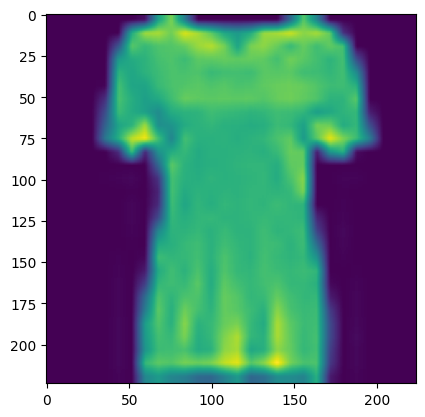

In [13]:
# visualize the images
import matplotlib.pyplot as plt

plt.imshow(train_dataset[10][0][1])